# B – Neutron-Nucleus Recoil Distributions

## Objective

This notebook computes the **distribution of nuclear recoil energies** resulting from **neutron elastic scattering**. This is a key input for background modeling in rare event searches, such as dark matter experiments.

The recoil energy deposited in a detector depends on:
- the energy of the incident neutron,
- the mass of the target nucleus,
- and the scattering kinematics.

By computing the differential recoil spectrum, we obtain insight into how neutrons of known energy deposit measurable signals into a materials like silicon and germanium.

---

We begin by selecting the target material and retrieving its atomic mass. This information is essential for determining the maximum possible energy transferred to a nucleus during an elastic collision.

We will then simulate neutrons with a fixed energy (e.g. 1 MeV). This energy governs how much kinetic energy is available to be transferred to the target nucleus.

Then we calculate the differential recoil cross section $\frac{d\sigma}{dE_r}$, which tells us how likely it is for a neutron of energy $E_n$ to produce a specific recoil energy $E_r$.

## Libraries and Style Files

In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
sys.path.append('../python/')

#matplotlib for plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('../mplstyles/stylelib/standard.mplstyle')

#math tools
import numpy as np
import pandas as pd
import scipy.constants as co
import ENDF6el as endfel

## Recoil Energy Distributions for Neutron-Nucleus Scattering

In the previous notebook `A-Differential-Neutron-Nucleus-XN.ipynb` we found out how our libraries can extract the Center-of-Mass (CoM) _angular_ differential cross sections for neutron scattering off nuclei. These cross sections describe the probability of scattering at different angles (in the center-of-mass frame). However, detectors do not directly measure angles—they measure recoil energy deposited by the recoiling nucleus. Therefore, we need to convert angular distributions into recoil energy distributions for each isotope. In other words, we transform the angular variable in the CoM (say, $cos\theta_{cm}$) into the energy deposited into the detector. 

### Energy Relationship

The relationship between the nuclear recoil energy $E_r$ and the CoM scattering angle $\theta_{cm}$ is:

\begin{equation}
E_r = \frac{2m_n M E_n}{(m_n + M)^2}\left(1-\cos{\theta_{cm}}\right),
\end{equation}

Where:<br /><br />
$E_r$ is the recoil energy of the nucleus.<br />
$E_n$ is the energy of the incident neutron.<br />
$m_n$ is the mass of the neutron.<br />
$M$ is the mass of the nucleus.<br />
$\theta_{cm}$ is the scattering angle in the center-of-mass frame.


### Load Differential Cross Section Data

We use the function `fetch_diff_xn()` to get the angular differential cross section, $\frac{d\sigma}{d\Omega}$ as a function of $cos\theta_{cm}$.

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import ENDF6el as endfel

# Generate Legendre coefficient interpolants for each Si and Ge isotope
acoeffs = {
    28: endfel.al(np.arange(64), endffile='../data_files/xn_data/n-014_Si_028.endf'),
    29: endfel.al(np.arange(64), endffile='../data_files/xn_data/n-014_Si_029.endf'),
    30: endfel.al(np.arange(64), endffile='../data_files/xn_data/n-014_Si_030.endf'),
    70: endfel.al(np.arange(64), endffile='../data_files/xn_data/n-032_Ge_070.endf'),
    72: endfel.al(np.arange(64), endffile='../data_files/xn_data/n-032_Ge_072.endf'),
    73: endfel.al(np.arange(64), endffile='../data_files/xn_data/n-032_Ge_073.endf'),
    74: endfel.al(np.arange(64), endffile='../data_files/xn_data/n-032_Ge_074.endf'),
    76: endfel.al(np.arange(64), endffile='../data_files/xn_data/n-032_Ge_076.endf')
}

# Load total elastic cross-section functions for Si and Ge isotopes
f_elastic = {
    28: endfel.fetch_elastic(filename='../data_files/xn_data/si28_el.txt'),
    70: endfel.fetch_elastic(filename='../data_files/xn_data/ge70_el.txt')
    # Add more if you have explicit .txt files for other isotopes, else use 28-Si and 70-Ge as defaults
}

# Build dictionary of differential cross section functions at 1 MeV
dsdomeg_funcs = {}
for A, acoeff in acoeffs.items():
    if A in f_elastic:
        f_el = f_elastic[A]
    else:
        f_el = f_elastic[28] if A < 50 else f_elastic[70]  # Default to 28-Si or 70-Ge

    dsdomeg_funcs[A] = endfel.fetch_diff_xn(En=1.0e6, f=f_el, a=acoeff)

## Encode Recoil Energy Formula for Silicon and Germanium

For each isotope, we precompute a factor that scales with the mass of the nucleus and determines how much of the neutron’s energy can be transferred in a recoil.

In [3]:
# import custom Python module containing atomic mass values
import masses as ms

# make a list of 100 evenly spaced values for cosθ
ct = np.linspace(-1.0, 1.0, 100)

# Define isotope data for Silicon (Z=14) and Germanium (Z=32). These atomic masses are needed to compute the recoil energy transfer factor for each isotope.
isotopes = {
    28: ms.getMass(14, 28),
    29: ms.getMass(14, 29),
    30: ms.getMass(14, 30),
    70: ms.getMass(32, 70),
    72: ms.getMass(32, 72),
    73: ms.getMass(32, 73),
    74: ms.getMass(32, 74),
    76: ms.getMass(32, 76)
}

# Precompute recoil energy fractions (escale) for each isotope
fac_dict = {}
for A, m in isotopes.items():
    fac_dict[A] = ms.m_n * m / (ms.m_n + m)**2

## Convert $\frac{d\sigma}{d\Omega}$ into $\frac{d\sigma}{dE_r}$.

Whereas we previously worked with cross section vs. angle, we now work with cross section vs. energy. Thus, we must convert the angular differential cross section into a recoil-energy distribution, for each isotope of both silicon and germanium.

Since scattering angle and recoil energy are related, we apply a Jacobian transformation when changing variables. This corrects for how the density of events “stretches” or “compresses” during the transformation from $\cos\theta_{cm}$ to $E_r$. The Jacobian depends on the recoil energy scaling factor, which is isotope-dependent due to the different target masses of each nucleus. We apply this for each silicon and germanium isotope individually.

In [4]:
# Relative abundances for isotopes (natural abundance)
isotope_abundances = {
    28: 0.92223,  # Si
    29: 0.04685,
    30: 0.03092,
    70: 0.2057,   # Ge
    72: 0.273,
    73: 0.0776,
    74: 0.367,
    76: 0.076
}

# Compute Jacobian factors for each isotope
jacobians = {}
for A, abundance in isotope_abundances.items():
    fac = A * (1 + A)**2
    jacobians[A] = (1 / (2 * fac)) * 2 * np.pi


## Plot Recoil Energy Distributions for Silicon and Germanium Isotopes

We now compute and plot $\frac{d\sigma}{dE_r}$ for several incident neutron energies (0.5 MeV, 1.0 MeV, and 1.5 MeV) across all isotopes of both silicon and germanium.

These distributions show how energy is transferred from neutrons to nuclei in the form of recoil. Each plot captures the range and likelihood of recoil energies produced by monoenergetic neutrons interacting with a specific isotope.

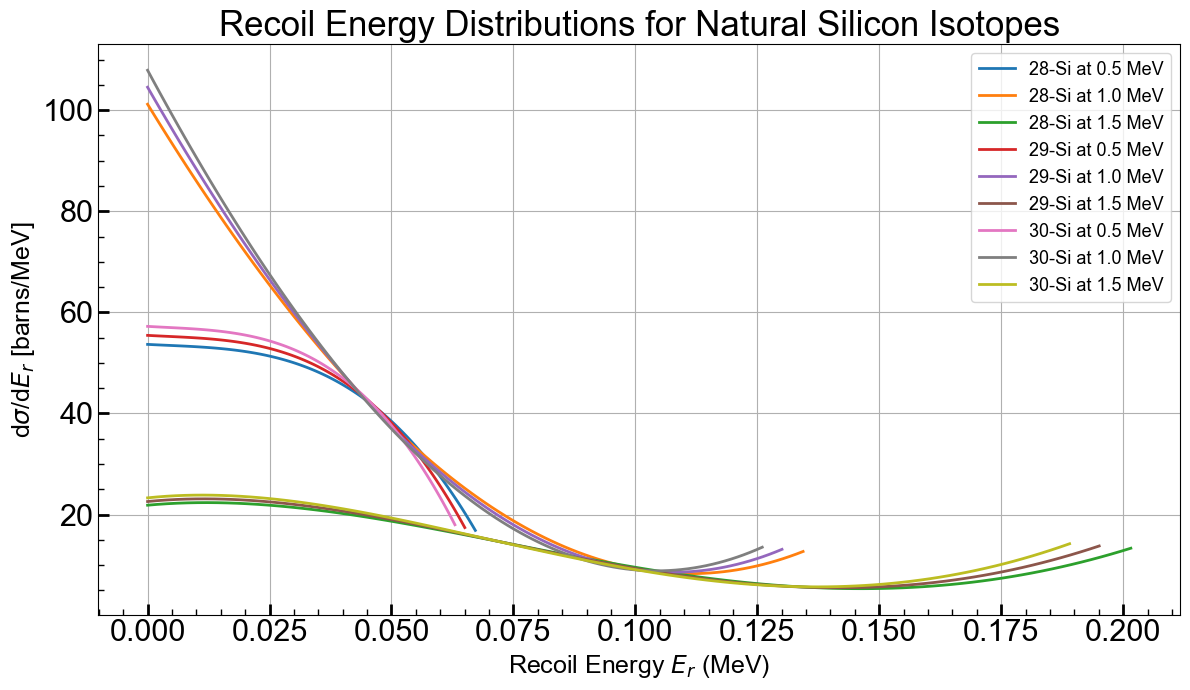

&nbsp;

&nbsp;



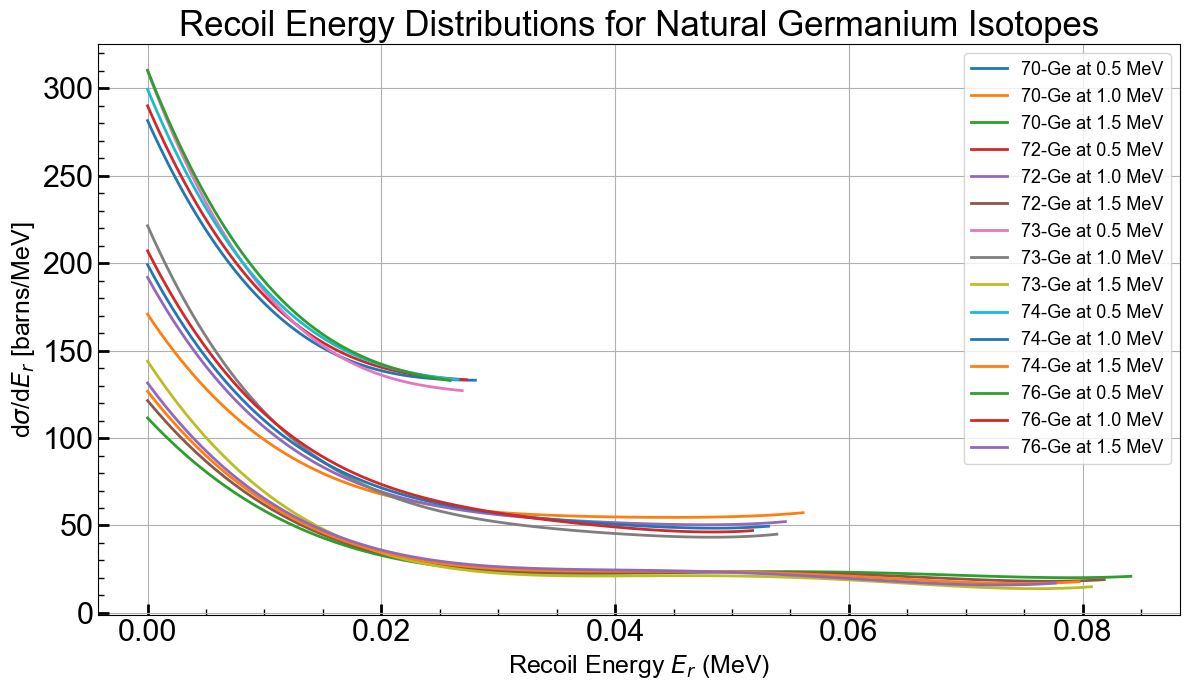

In [5]:
# List of incident neutron energies (in MeV)
energies = [0.5, 1.0, 1.5]

# Set up the plot for Silicon
plt.figure(figsize=(12, 7))

for A in isotope_abundances:
    if A >= 50:  # skip Ge for this plot
        continue

    fac = fac_dict[A]
    for E_n in energies:
        escale = 2 * fac * (1 - ct)
        er_vals = E_n * escale

        if E_n == 1.0:
            dsdomeg = dsdomeg_funcs[A]
        else:
            f_el = f_elastic[28]
            dsdomeg = endfel.fetch_diff_xn(En=E_n * 1e6, f=f_el, a=acoeffs[A])

        dsdomegv = np.vectorize(dsdomeg)
        jac = (1 / (2 * fac)) * 2 * np.pi
        dsig_dEr = (jac / E_n) * dsdomegv(ct)
        plt.plot(er_vals, dsig_dEr, label=f"{A}-Si at {E_n} MeV")

plt.xlabel('Recoil Energy $E_r$ (MeV)', fontsize=18)
plt.ylabel(r'd$\sigma$/d$E_r$ [barns/MeV]', fontsize=18)
plt.title('Recoil Energy Distributions for Natural Silicon Isotopes', fontsize=25)
plt.grid(True)
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

# Spacer
from IPython.display import display, Markdown
display(Markdown("&nbsp;\n\n&nbsp;\n\n"))  # Adds vertical space


# Set up the plot for Germanium
plt.figure(figsize=(12, 7))

for A in isotope_abundances:
    if A < 50:  # skip Si for this plot
        continue

    fac = fac_dict[A]
    for E_n in energies:
        escale = 2 * fac * (1 - ct)
        er_vals = E_n * escale

        if E_n == 1.0:
            dsdomeg = dsdomeg_funcs[A]
        else:
            f_el = f_elastic[70]
            dsdomeg = endfel.fetch_diff_xn(En=E_n * 1e6, f=f_el, a=acoeffs[A])

        dsdomegv = np.vectorize(dsdomeg)
        jac = (1 / (2 * fac)) * 2 * np.pi
        dsig_dEr = (jac / E_n) * dsdomegv(ct)
        plt.plot(er_vals, dsig_dEr, label=f"{A}-Ge at {E_n} MeV")

plt.xlabel('Recoil Energy $E_r$ (MeV)', fontsize=18)
plt.ylabel(r'd$\sigma$/d$E_r$ [barns/MeV]', fontsize=18)
plt.title('Recoil Energy Distributions for Natural Germanium Isotopes', fontsize=25)
plt.grid(True)
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

## Plot Interpretations: Recoil Energy Distributions

The recoil energy spectra shown above illustrate how neutron elastic scattering deposits energy in silicon and germanium detectors. These distributions are computed for incident neutrons of 0.5 MeV, 1.0 MeV, and 1.5 MeV.

Each curve shows how likely it is for a neutron of a given energy to produce a particular nuclear recoil energy $E_r$ in a specific isotope. The height of each curve reflects the differential cross section at that energy, and the width of the distribution shows the kinematic range of accessible recoil energies.

As the incident neutron energy increases, the maximum recoil energy shifts higher, reflecting increased momentum transfer to the nucleus. Lighter isotopes (like $^{28}$Si) can receive more recoil energy than heavier isotopes (like $^{76}$Ge), because energy and momentum conservation favor greater transfers to lighter targets.

The shape of the recoil spectrum is strongly influenced by the angular differential cross section in the CoM frame and by the Jacobian relating angle to energy. Some isotopes exhibit more forward-peaked scattering, resulting in lower recoil energies; others allow broader angular scattering and thus a wider range of energy deposition.

## Nuclear Masses Used in Calculations

To accurately compute recoil kinematics, we use atomic mass values (in atomic mass units, u) for both neutrons and target nuclei. These masses are used to calculate the maximum possible recoil energy and Jacobian factors for converting angular cross sections to recoil energy spectra.

**Mass of neutron** ([NIST - Neutron][nist-neutron]):

$m_n$ = 1.00866491606 u

**Silicon isotopes** ([NIST - Silicon][nist-si]):

$^{28}$Si: 27.97692653465 u

$^{29}$Si: 28.97649466490 u

$^{30}$Si: 29.97377013600 u


**Germanium isotopes** ([NIST - Germanium][nist-ge]):

$^{70}$Ge: 69.92424875 u

$^{72}$Ge: 71.922075826 u

$^{73}$Ge: 72.923458956 u

$^{74}$Ge: 73.921177761 u

$^{76}$Ge: 75.921402726 u


[nist-neutron]: https://physics.nist.gov/cgi-bin/cuu/Value?mnu "NIST - Neutron Documentation"
[nist-si]: https://physics.nist.gov/cgi-bin/Compositions/stand_alone.pl?ele=Si "NIST - Silicon Mass Data"
[nist-ge]: https://physics.nist.gov/cgi-bin/Compositions/stand_alone.pl?ele=Ge "NIST - Germanium Mass Data"